In [93]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import shutil
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

## Setting up our directories

In [2]:
data_dir = "E:\\Conda Projects\\dog-vs-cats"

In [3]:
train_dir = data_dir +"\\train\\train"

In [4]:
test_dir = data_dir + "\\test1\\test1"

## Pulling out the first image in our training dataset

In [5]:
first_pic = os.listdir(train_dir)[0]

In [6]:
print(first_pic)

cat.0.jpg


In [7]:
first_cat = train_dir+"\\cat.0.jpg"
print(first_cat)

E:\Conda Projects\dog-vs-cats\train\train\cat.0.jpg


In [8]:
first_cat = plt.imread(first_cat)

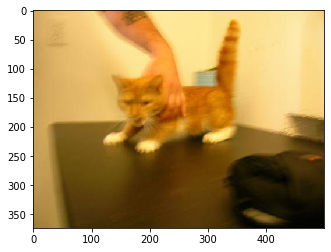

In [9]:
plt.imshow(first_cat)

In [10]:
len(os.listdir(train_dir))

25000

## We have 25000 images in our dataset

## Since all images may not be of the same resolution we have to figure out a target size, for this we will use the mean of the dimensions of the given images

In [11]:
dim1 = []

dim2 = []

for images in os.listdir(train_dir):
    img = plt.imread(train_dir+"\\"+images)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

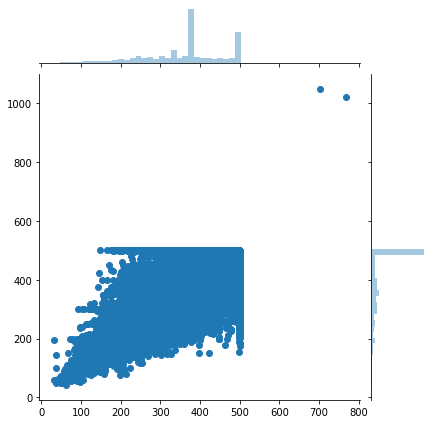

In [12]:
sns.jointplot(dim1,dim2)

In [13]:
np.mean(dim1)

360.47808

In [14]:
np.mean(dim2)

404.09904

In [15]:
image_shape = (360,404,3)
batch_size = 8

## We convert our image dataset into a dataframe

In [16]:
filenames = os.listdir(train_dir)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df = df.sample(frac=1)
df = df.reset_index(drop=True)
df.head()

,filename,category
0,cat.5669.jpg,0
1,dog.3572.jpg,1
2,dog.2922.jpg,1
3,cat.11378.jpg,0
4,dog.3722.jpg,1


In [17]:
df.tail()

,filename,category
24995,dog.9991.jpg,1
24996,dog.11382.jpg,1
24997,dog.4150.jpg,1
24998,cat.1530.jpg,0
24999,dog.10890.jpg,1


## The images are distributed equally in over both the categories

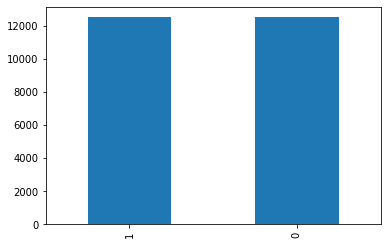

In [18]:
df['category'].value_counts().plot.bar()

## Making our model

In [19]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 358, 402, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 358, 402, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 179, 201, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 179, 201, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 177, 199, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 177, 199, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 99, 64)        0

## We setup an early stopping callback, if the validation loss doesn't improve in the patience period(in this case 12 epochs) we will stop training

In [23]:
stop = EarlyStopping(patience=12)

In [24]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [25]:
df.head()

,filename,category
0,cat.5669.jpg,cat
1,dog.3572.jpg,dog
2,dog.2922.jpg,dog
3,cat.11378.jpg,cat
4,dog.3722.jpg,dog


## Generating a dataset from our images and splitting that dataset into training and validation dataset

In [26]:
train_df, validation_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [27]:
train_datagen = ImageDataGenerator(rotation_range=10,
                              rescale=1/255,
                              shear_range=0.1,
                              zoom_range=0.2,
                              horizontal_flip=True)

In [28]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_dir, 
    x_col='filename',
    y_col='category',
    target_size=image_shape[0:2],
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [29]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [30]:
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    train_dir, 
    x_col='filename',
    y_col='category',
    target_size=image_shape[0:2],
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [31]:
example = train_df.sample(n=1).reset_index(drop=True)
example_gen = train_datagen.flow_from_dataframe(
    example, 
    train_dir, 
    x_col='filename',
    y_col='category',
    target_size=image_shape[0:2],
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


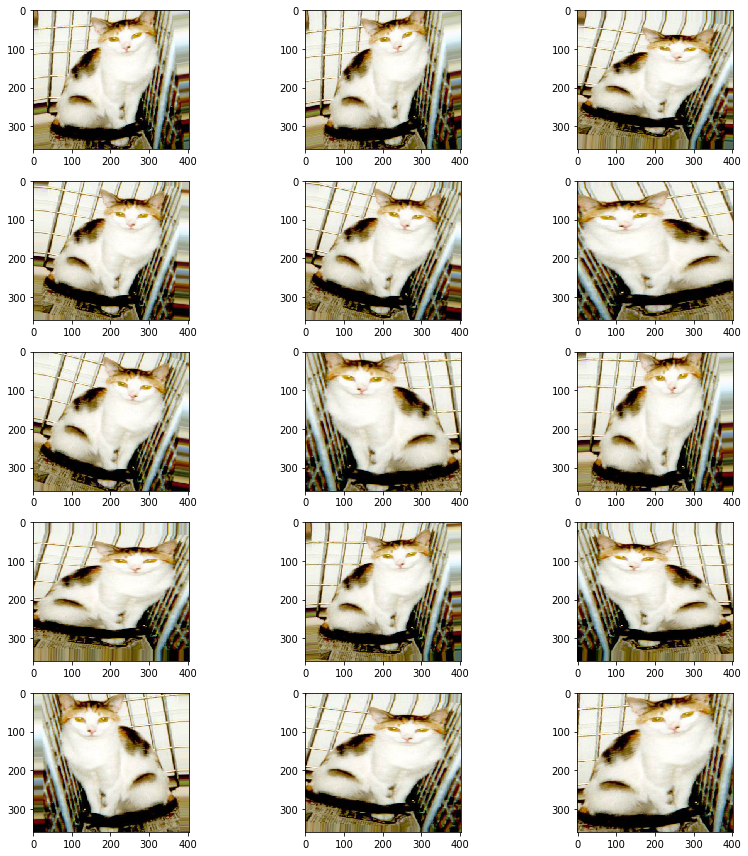

In [32]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_gen:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Training our model. If you want to run the code in your system do not run the below cell unless you have a very powerful GPU since training will take upwards of 10 hours. Comment out the below cell if you want to use my pre-trained model

In [33]:
model.fit_generator(train_generator,
                   epochs = 50,
                   validation_data=validation_generator,
                   callbacks = [stop])

Epoch 1/50
2500/2500 [==============================] - 1030s 412ms/step - loss: 0.7694 - accuracy: 0.5730 - val_loss: 0.6483 - val_accuracy: 0.6120
Epoch 2/50
2500/2500 [==============================] - 965s 386ms/step - loss: 0.6728 - accuracy: 0.6187 - val_loss: 0.6518 - val_accuracy: 0.6366
Epoch 3/50
2500/2500 [==============================] - 984s 394ms/step - loss: 0.6393 - accuracy: 0.6523 - val_loss: 0.6081 - val_accuracy: 0.6666
Epoch 4/50
2500/2500 [==============================] - 971s 388ms/step - loss: 0.6112 - accuracy: 0.6740 - val_loss: 0.9115 - val_accuracy: 0.5682
Epoch 5/50
2500/2500 [==============================] - 943s 377ms/step - loss: 0.5923 - accuracy: 0.6912 - val_loss: 0.5302 - val_accuracy: 0.7358
Epoch 6/50
2500/2500 [==============================] - 946s 379ms/step - loss: 0.5660 - accuracy: 0.7098 - val_loss: 0.4694 - val_accuracy: 0.7736
Epoch 7/50
2500/2500 [==============================] - 970s 388ms/step - loss: 0.5291 - accuracy: 0.7377 - val

In [36]:
model.save('dogvcat.h5')

## Uncomment the below cell if you want to use the pre-trained model

In [92]:
#model = load_model('dogvcat.h5')

## Plotting our losses and accuracies during the training time

In [37]:
losses = pd.DataFrame(model.history.history)

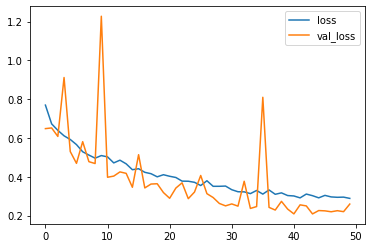

In [39]:
losses[['loss','val_loss']].plot()

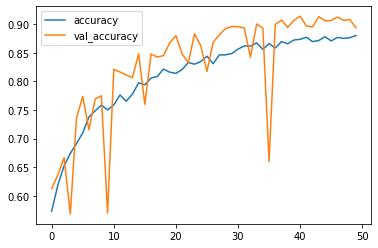

In [42]:
losses[['accuracy','val_accuracy']].plot()

## Now we will predict the classes of  unlabeled images

In [44]:
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({
    'filename': test_filenames
})

In [45]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test_dir, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=image_shape[0:2],
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [46]:
predictions = model.predict_generator(test_generator)

In [47]:
predictions

array([[0.08215339, 0.9178466 ],
       [0.99540764, 0.00459234],
       [0.97210836, 0.02789167],
       ...,
       [0.22509299, 0.77490705],
       [0.98630863, 0.01369137],
       [0.8839317 , 0.11606833]], dtype=float32)

## Since our predictions array gives the probability of the image of belonging to each category. So we will pick the category having the higher probability

In [48]:
test_df['category'] = np.argmax(predictions, axis=-1)

In [49]:
test_df

,filename,category
0,1.jpg,1
1,10.jpg,0
2,100.jpg,0
3,1000.jpg,1
4,10000.jpg,1
...,...,...
12495,9995.jpg,0
12496,9996.jpg,1
12497,9997.jpg,1
12498,9998.jpg,0


In [62]:
test_df['category'] = test_df['category'].replace({1:'dog', 0:'cat'})

## Lets check our predictions for a few images

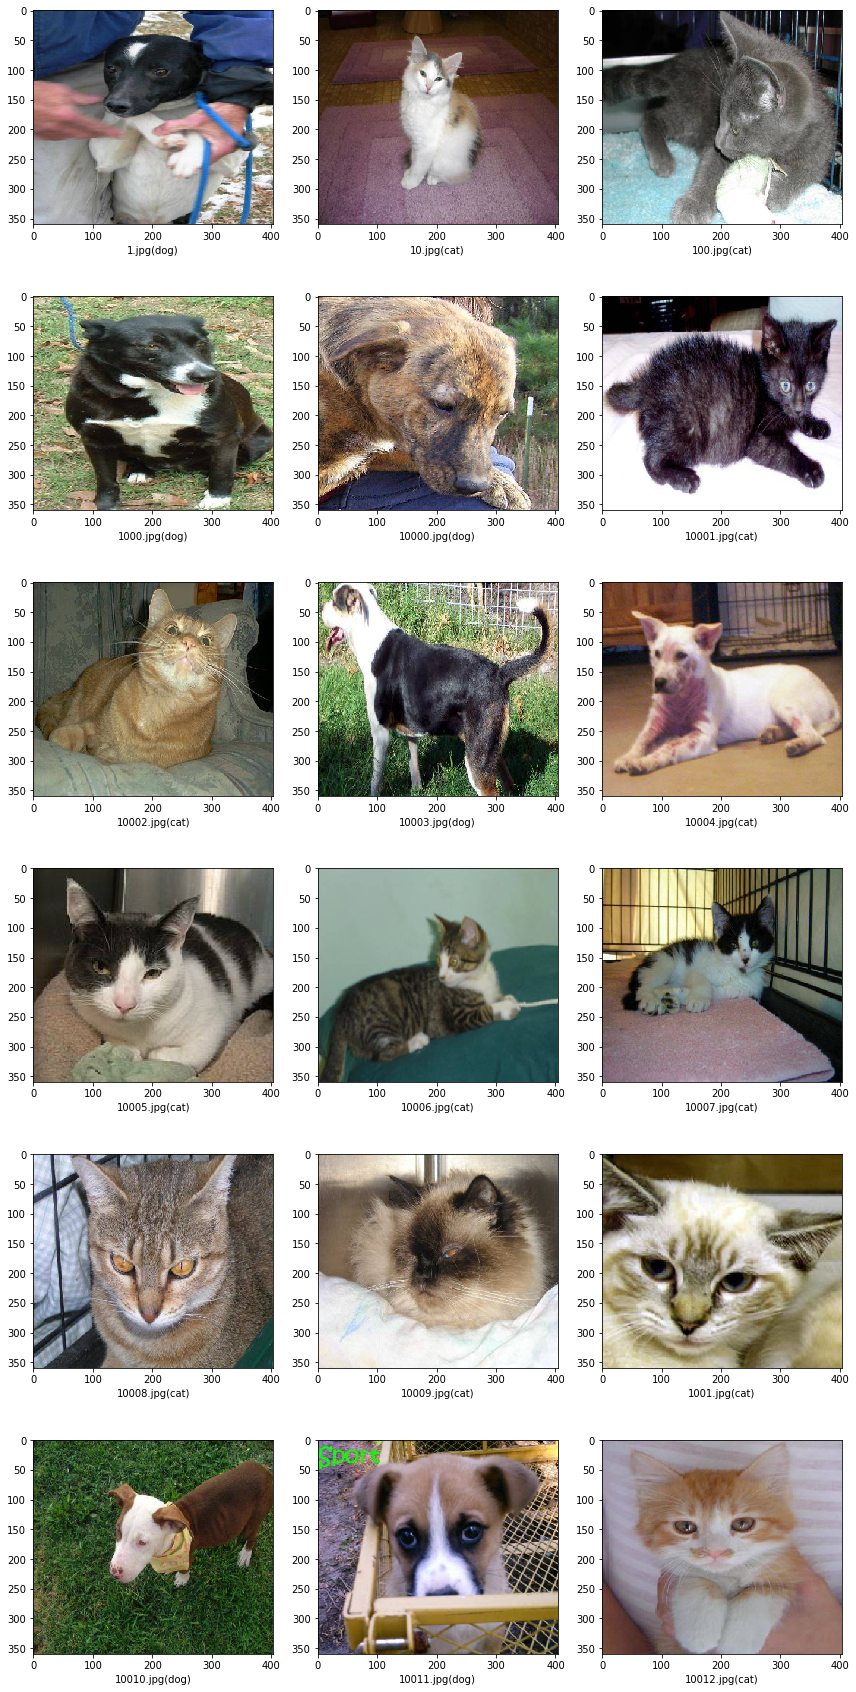

In [65]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(test_dir+"/"+filename, target_size=image_shape[0:2])
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## Since our test images are unlabelled it isn't possible to get the accuracy of our model for test data 